filtering.ipynb

Author: Anderson Steckler

This imports the data calculated from "tbinding_ldos.ipynb" and filters around the backscattering points

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import skimage

import pybinding as pb
from pybinding.repository import graphene

import os

from tqdm import tqdm

### Importing Data

In [21]:
%matplotlib inline

In [22]:
!mkdir freqout

mkdir: cannot create directory ‘freqout’: File exists


In [23]:
fpath = r"Calculations/graphene_delta_0d2_AP100_sbA/continous_ldos.csv"
df=pd.read_csv(fpath)
df.head()

,Unnamed: 0,x,y,Re(z),Im(z),MeshSize,DiscreteSize,LDOS Energy
0,0,-20.00000,-20.0,0.003605,0.0,1000,20,0.2
1,1,-19.95996,-20.0,0.004877,0.0,1000,20,0.2
2,2,-19.91992,-20.0,0.005860,0.0,1000,20,0.2
3,3,-19.87988,-20.0,0.006377,0.0,1000,20,0.2
4,4,-19.83984,-20.0,0.006446,0.0,1000,20,0.2


In [24]:
# Get the sample name to use on graphs from directory
dir_path = os.path.dirname(fpath)
sample_name = os.path.basename(dir_path)
print(sample_name)

graphene_delta_0d2_AP100_sbA


In [25]:
w = int(np.sqrt(np.size(df['x'])))

x = np.reshape(df['x'], (w, w))
y = np.reshape(df['y'], (w, w))
z = np.reshape(df['Re(z)'] + 1j * df['Im(z)'], (w, w)).astype(np.complex128)

Text(0.5, 1.0, 'Continuous Spatial LDOS')

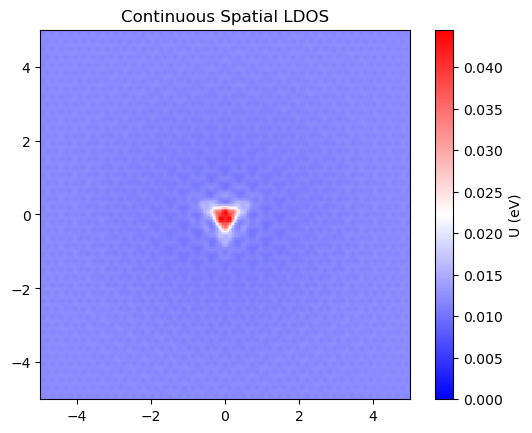

In [26]:
fig3, ax3 = plt.subplots()

z_min, z_max = 0, np.abs(z).max()

c = ax3.pcolormesh(x, y, np.abs(z), cmap='bwr', vmin=z_min, vmax=z_max)
ax3.axis([x.min(), x.max(), y.min(), y.max()])
fig3.colorbar(c, ax=ax3, label="U (eV)")
ax3.set_aspect("equal")
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)

ax3.set_title("Continuous Spatial LDOS")
#fig3.savefig("output/continuous_ldos.png")

### FFT and Filtering

In [27]:
# Answering Question: Are these values evenly spaced??
ux, uy = np.unique(df['x']), np.unique(df['y'])
dx = np.array([ux[i+1] - ux[i] for i in range(0, len(ux)-1)])
dy = np.array([uy[i+1] - uy[i] for i in range(0, len(uy)-1)])

dxm = np.average(dx)
dym = np.average(dy)

print(dx[0:20])
print(np.average(dx), np.std(dx))
print("")
print(dy[0:20])
print(np.average(dy), np.std(dy))

[0.04004004 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004
 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004
 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004
 0.04004004 0.04004004]
0.04004004004004004 3.289565222167124e-16

[0.04004004 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004
 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004
 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004 0.04004004
 0.04004004 0.04004004]
0.04004004004004004 3.289565222167124e-16


Text(0.5, 1.0, '2D FFT: graphene_delta_0d2_AP100_sbA')

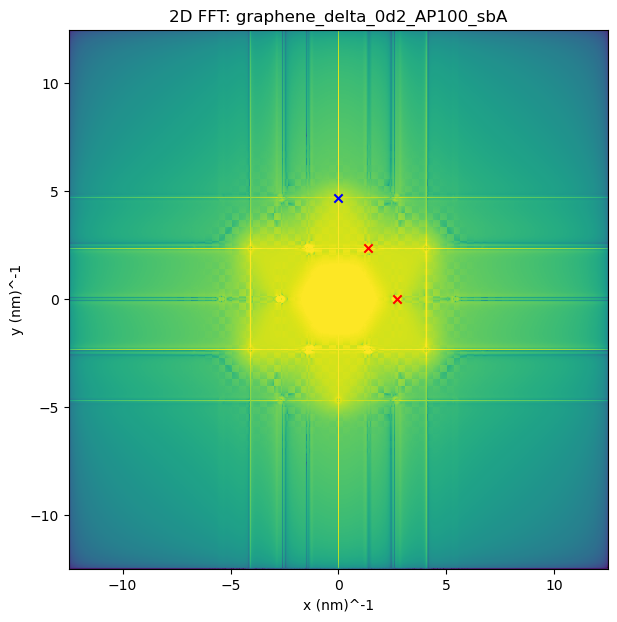

In [28]:
# FFT
ftz = np.fft.fft2(z)
ftz = np.fft.fftshift(ftz) # Shifts zero component freq to center

# Log scale
plz = np.log(np.abs(ftz ** 2)) # I FOUND THE SQUARE?

# Recreating linspace
#l = np.linspace(-20, 20, 1000)
#stepl = l[1] - l[0]
#fx = np.fft.fftfreq(len(l), stepl)
#fy = np.fft.fftfreq(len(l), stepl)
#fxs = np.fft.fftshift(fx)
#fys = np.fft.fftshift(fy)

# Using df['x'] and df['y'] spacing
fx = np.fft.fftfreq(len(ux), dxm)
fy = np.fft.fftfreq(len(uy), dym)
fxs = np.fft.fftshift(fx)
fys = np.fft.fftshift(fy)

fig4, ax4 = plt.subplots(figsize=(7, 7))
ax4.pcolormesh(fxs, fys, plz, vmax=np.mean(plz)/100)

# From liu
a=0.24595 #nm
acc=0.142 #nm
deltaKx = 4 * np.pi / (3 * np.sqrt(3) * acc) * (1/(2 * np.pi))

# Rotate by 60 to get other point
# This comes from rotation matrix
dKR_x = 0.5 * deltaKx
dKR_y = np.sqrt(3)/2 * deltaKx

# Plotting delta K Point
ax4.scatter(deltaKx, 0, marker='x', color='red')

frac = (2 * np.pi)/(3 * a)
bx = np.sqrt(frac ** 2 + 3 * (frac) ** 2) # Spatial lattice point
ax4.scatter(0, np.sqrt(3) * (bx) * (1/(2 * np.pi)), marker='x', color='blue')
ax4.scatter(dKR_x, dKR_y, marker='x', color='red')

ax4.set_xlabel("x (nm)^-1")
ax4.set_ylabel("y (nm)^-1")
ax4.set_aspect("equal")

ax4.set_title("2D FFT: " + sample_name)

#fig4.savefig("freqout/fft.png")

In [29]:
# Periodic 1D Hann Function
def hann1dp(x, N, x0):
    return np.cos(np.pi * (x-x0)/N) ** 2

def hann2d(x, y, Nx, Ny, x0, y0): 
    val = hann1dp(x, Nx, x0) * hann1dp(y, Ny, y0)

    return np.where((np.abs(x-x0) <= 0.5 * Nx) & (np.abs(y-y0) <= 0.5 * Ny), val, 0)

hann_vec = np.vectorize(hann2d)

In [30]:
# Hann Filtering
ffx, ffy = np.meshgrid(fxs, fys)
rad = 0.3
hann_z = hann2d(ffx, ffy, 2 * rad, 2 * rad, dKR_x, dKR_y) + hann2d(ffx, ffy, 2 * rad, 2 * rad, -dKR_x, -dKR_y)

ftzf = ftz * hann_z
plzf = plz * hann_z

(-5.0, 5.0)

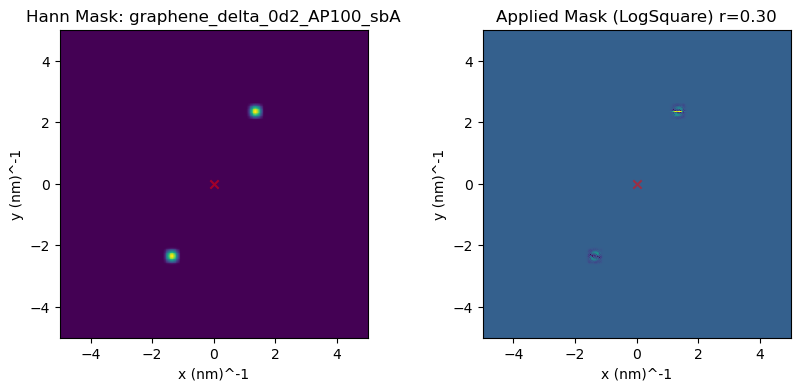

In [31]:
fig6, axs6 = plt.subplots(1, 2, figsize=(10, 4))

axs6[0].set_xlabel("x (nm)^-1")
axs6[0].set_ylabel("y (nm)^-1")
axs6[0].set_aspect("equal")

axs6[0].pcolormesh(fxs, fys, hann_z)
axs6[0].set_aspect("equal")

axs6[0].scatter(0, 0, marker="x", color='red', alpha=0.5)

axs6[0].set_title("Hann Mask: " + sample_name)

axs6[0].set_xlim(-5, 5)
axs6[0].set_ylim(-5, 5)

###

axs6[1].set_xlabel("x (nm)^-1")
axs6[1].set_ylabel("y (nm)^-1")
axs6[1].set_aspect("equal")

axs6[1].pcolormesh(fxs, fys, plzf)
axs6[1].set_aspect("equal")

axs6[1].scatter(0, 0, marker="x", color='red', alpha=0.5)

axs6[1].set_title(f"Applied Mask (LogSquare) r={rad:.2f}")

axs6[1].set_xlim(-5, 5)
axs6[1].set_ylim(-5, 5)

#fig6.savefig("freqout/mask.png")

In [75]:
np.sum(np.abs(np.imag(ftzf)))

319.52108806464423

(-5.0, 5.0)

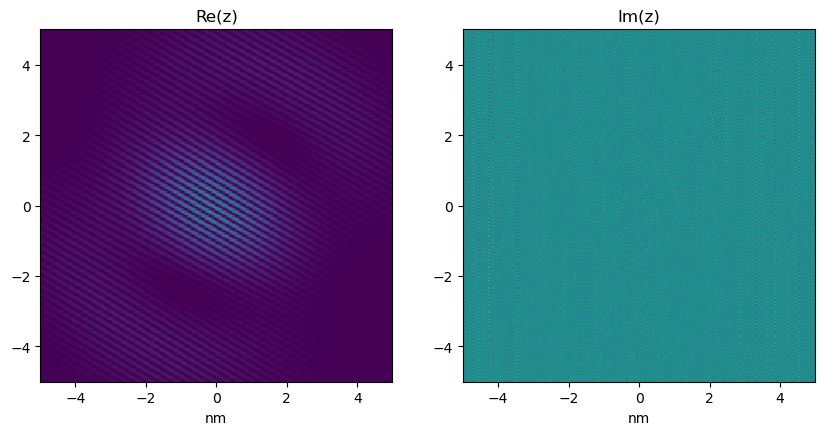

In [83]:
fig9, axs9 = plt.subplots(1, 2, figsize=(10, 5))

z_filtered = np.fft.ifft2(ftzf)

axs9[0].pcolormesh(ux, uy, np.real(z_filtered) ** 2)
axs9[0].set_aspect('equal')
axs9[0].set_title('Re(z)')
axs9[0].set_xlabel('nm')
axs9[0].set_xlim(-5, 5)
axs9[0].set_ylim(-5, 5)

axs9[1].pcolormesh(ux, uy, np.imag(z_filtered))
axs9[1].set_aspect('equal')
axs9[1].set_title('Im(z)')
axs9[1].set_xlabel('nm')
axs9[1].set_xlim(-5, 5)
axs9[1].set_ylim(-5, 5)

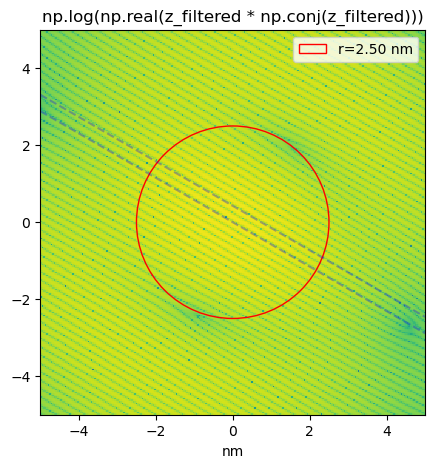

In [79]:
fig10, ax10 = plt.subplots(figsize=(5, 5))

z_filtered = np.fft.ifft2(ftzf)
zfls = np.log(np.real(z_filtered * np.conj(z_filtered)))

ax10.pcolormesh(ux, uy, zfls)
ax10.set_aspect('equal')
ax10.set_title('np.log(np.real(z_filtered * np.conj(z_filtered)))')
ax10.set_xlabel('nm')
ax10.set_xlim(-5, 5)
ax10.set_ylim(-5, 5)

crad = 2.5
crc = plt.Circle((0, 0), crad, color='red', fill=False)

ax10.add_patch(crc)
ax10.legend([f'r={crad:.2f} nm'])

m1, b1 = -dKR_x/dKR_y, 0
xlin = np.linspace(-5, 5, 100)
ax10.plot(xlin, m1 * (xlin) + (b1), 'blue', linestyle='dashed', alpha=0.3)

wavel = 2 * np.pi / np.sqrt(dKR_x ** 2 + dKR_y ** 2) * 1/(np.pi * 2)
b2 = (m1 ** 2 + 1)/np.sqrt(m1 ** 2 + 1) * wavel
ax10.plot(xlin, m1 * (xlin) + b2, 'blue', linestyle='dashed', alpha=0.3)


In [64]:
# This is absolute value
print(np.mean(zflabs_C), np.min(zflabs_C), np.max(zflabs_C))

2.4856063069030386e-05 3.418260501042436e-13 0.0003169079785723094


In [76]:
np.sum(np.abs(np.imag(z_filtered)))

6.583975081138904e-15

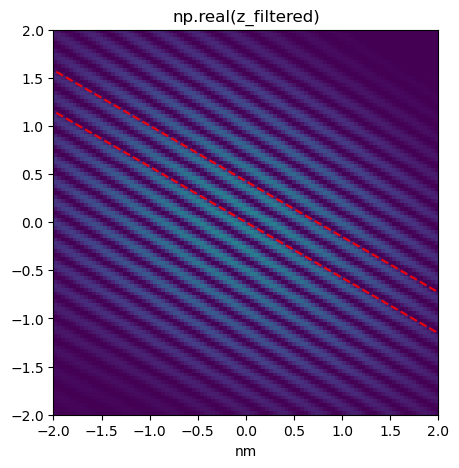

In [86]:
fig11, ax11 = plt.subplots(figsize=(5, 5))

z_filtered = np.fft.ifft2(ftzf)
zfls = np.real(z_filtered)
zflabs = np.abs(z_filtered)
zflabs_C = np.abs(np.real(z_filtered)) ** 2

ax11.pcolormesh(ux, uy, zflabs_C)
ax11.set_aspect('equal')
ax11.set_title('np.real(z_filtered)')
ax11.set_xlabel('nm')
ax11.set_xlim(-2, 2)
ax11.set_ylim(-2, 2)

ax11.plot(xlin, m1 * (xlin) + (b1), 'red', linestyle='dashed', alpha=0.9)
ax11.plot(xlin, m1 * (xlin) + b2, 'red', linestyle='dashed', alpha=0.9)



In [35]:
# Circle Filtering

# Convert to index value
#x1, y1, r1 = 1.36, 2.35, 0.25
#x2, y2, r2 = -1.36, -2.35, 0.25

#x1, y1, r1 = 2.7, 0, 0.4
#x2, y2, r2 = -2.7, 0, 0.4

#ffx, ffy = np.meshgrid(fxs, fys)

#dist = np.sqrt((ffx - x1) ** 2 + (ffy - y1) ** 2)
#mask = dist >= r1

#dist2 =  np.sqrt((ffx - x2) ** 2 + (ffy - y2) ** 2)
#mask2 = dist2 >= r1

#plzf = np.where(mask, 0, plz) + np.where(mask2, 0, plz)
#ftzf = np.where(mask, 0, ftz) + np.where(mask2, 0, ftz)

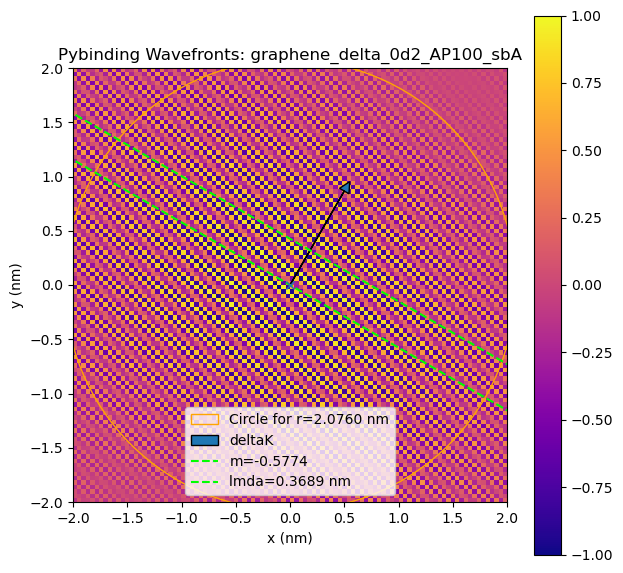

In [36]:
z_filtered = np.fft.ifft2(ftzf)

fig7, ax7 = plt.subplots(figsize=(7,7))

#zlog = np.log(np.abs(z_filtered))
zabs = np.real(z_filtered)

# Code to multiply by rsquared
# Currently interested in the near behavior
# CGPT: get subset between x,y \in [-5, 5]
ws = 5
mask3 = (x >= -ws) & (x <= ws) & (y >= -ws) & (y <= ws)
zw = int(np.sqrt(len(zabs[mask3])))
zsub = zabs[mask3].reshape(zw, zw) #reshape since mask flattens
xsub = x[mask3].reshape(zw, zw)
ysub = y[mask3].reshape(zw, zw)

# Multiply by R2
#RR = xsub ** 2 + ysub ** 2
#zr = zsub * RR

# normalize linear scale
# Normalized to from between -1 and 1
minval, maxval = np.min(zsub), np.max(zsub)

zn = (zsub - minval)/(maxval-minval) # Normalize
zn = 2 * zn - 1 # Normalize to -1 1

c = ax7.pcolormesh(xsub,ysub,zn,cmap='plasma')

fig7.colorbar(c, ax=ax7)

#circ = plt.Circle((0, 0), 3.49353451, fill=False)
#ax7.add_patch(circ)

ax7.set_aspect('equal')
#ax7.set_xlim(-5, 5)
#ax7.set_ylim(-5, 5)
ax7.set_xlabel("x (nm)")
ax7.set_ylabel("y (nm)")

ax7.set_title("Pybinding Wavefronts: " + sample_name)


# Plotting Circle
cr = 2.0760#nm
circle = plt.Circle((0, 0), cr, fill=False, color='orange')
ax7.add_patch(circle)

# Plotting DK
mDK = np.sqrt(dKR_x ** 2 + dKR_y ** 2)
ax7.arrow(0, 0, dKR_x/mDK, dKR_y/mDK, head_width=0.1, head_length=0.1)
mDK = mDK * 2 * np.pi # still need to convert

# Plotting perpendicular to DK
m1, b1 = -dKR_x/dKR_y, 0
xlinf = np.linspace(-5, 5, 100)
ax7.plot(xlinf, m1 * xlinf + b1, 'lime', linestyle='dashed')

# Plotting wavelength
wavel = 2 * np.pi / mDK
# After some geometry
b2 = (m1 ** 2 + 1)/np.sqrt(m1 ** 2 + 1) * wavel
ax7.plot(xlinf, m1 * xlinf + b2, 'lime', linestyle='dashed')

ax7.legend([f"Circle for r={cr:.4f} nm", "deltaK", f"m={m1:.4f}", f"lmda={wavel:.4f} nm"])

ax7.plot(0, 0, marker="x")

ax7.set_xlim(-2, 2)
ax7.set_ylim(-2, 2)

plt.show()

#fig7.savefig("freqout/wavefronts.png")

### Trying to fit lines

NameError: name 'zlog' is not defined

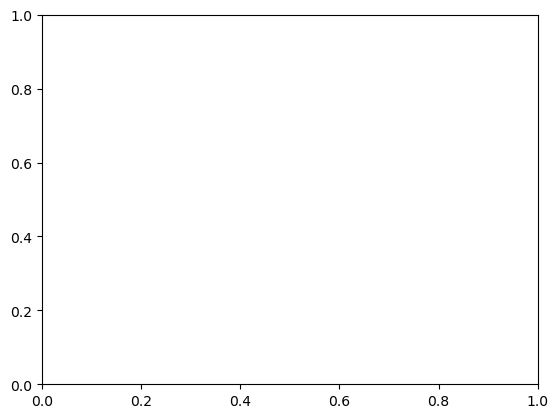

In [37]:
fig8, ax8 = plt.subplots()

c = ax8.pcolormesh(x,y,zlog,vmin=-15, vmax=-8, cmap='bwr')

fig8.colorbar(c, ax=ax8)

ax8.set_aspect('equal')
ax8.set_xlim(-5, 5)
ax8.set_ylim(-5, 5)
ax8.set_xlabel("x (nm)")
ax8.set_ylabel("y (nm)")

m1, b1 = -0.57, 0
xlin = np.linspace(-4, 4)
ax8.plot(xlin, m1 * xlin + b1)
ax8.legend([f'm={m1:.2f}'])

ax8.set_title("Wavefronts: " + sample_name)